In [1]:
from langchain import OpenAI
from langchain.agents import AgentType, initialize_agent
from langchain.agents import Tool, tool
from langchain import agents
import langchain
import os
import requests
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import sys
sys.path.append('transformer/')


from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI

from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
Embedding_model = 'text-embedding-ada-002' 

from langchain.text_splitter import CharacterTextSplitter


In [2]:
from langchain.memory import ConversationBufferMemory

RetrievalQA_prompt = """What are the design guidelines for making the MOF have a lower band gap? 
    This can be based on making changes to the functional groups, metal nodes or organic linkers. Summarize answer"""
def RetrievalQABypassTokenLimit(vector_store, RetrievalQA_prompt, llm, k=10, fetch_k=50, min_k=4, chain_type="stuff"):
    while k >= min_k:
            try:
                retriever = vector_store.as_retriever(
                    search_type="mmr",
                    search_kwargs={"k": k, "fetch_k": fetch_k},
                )
                qa_chain = RetrievalQA.from_chain_type(
                    llm=llm,
                    chain_type=chain_type,
                    retriever=retriever,
                    memory=ConversationBufferMemory(
                            ))
                
                # Check to see if we hit the token limit
                result = qa_chain.run({"query": RetrievalQA_prompt})
                return result  # If successful, return the result and exit the function
    
            except Exception as e:
                # If an error is caught, reduce the value of k and retry
                # print(e)
                print(
                    f"\nk={k} results hitting the token limit for the chosen LLM. Reducing k and retrying...\n"
                )
                k -= 1

@tool
def lookup_papers(prompt):
    '''This tool looks up design guidelines for a MOF with lower band gap by looking through research papers.
    '''
    guide_lines = []
    for m in range(7):
        text_splitter = CharacterTextSplitter(
            chunk_size=500, chunk_overlap=20)
        paper_file =f'../data/papers/{m}.pdf'
        pages = PyPDFLoader(paper_file).load_and_split()
        sliced_pages = text_splitter.split_documents(pages)
        faiss_vectorstore = FAISS.from_documents(sliced_pages, OpenAIEmbeddings(model=Embedding_model))
        
        llm=ChatOpenAI(
                        model_name='gpt-4',
                        temperature=0.1,
                        )
        g = RetrievalQABypassTokenLimit(faiss_vectorstore, RetrievalQA_prompt, llm)
        guide_lines.append(g)
        # break
    return guide_lines

guidel_lines = lookup_papers("")
guidel_lines


k=10 results hitting the token limit for the chosen LLM. Reducing k and retrying...


k=9 results hitting the token limit for the chosen LLM. Reducing k and retrying...


k=10 results hitting the token limit for the chosen LLM. Reducing k and retrying...


k=10 results hitting the token limit for the chosen LLM. Reducing k and retrying...


k=10 results hitting the token limit for the chosen LLM. Reducing k and retrying...


k=10 results hitting the token limit for the chosen LLM. Reducing k and retrying...



['To achieve an efficient semiconductor MOF with a lower bandgap, the following strategies can be employed: \n\n1) Increasing the conjugation in the linker: This can lead to a higher valence-band (HOMO) energy, hence reducing the bandgap.\n\n2) Selecting electron-rich metal nodes: Choosing appropriate metal nodes at octahedral coordination sites with their unoccupied d-orbitals below the LUMO of the organic linker can also decrease the bandgap.\n\n3) Functionalizing the linker with nitro and amino groups: The organic linker can be modified with various functional groups such as -NH2, -OH, -CH3, -Cl, which may donate 2p electrons to the aromatic linker, resulting in a band shift and thus reducing the bandgap.',
 'The band gap in Metal-Organic Frameworks (MOFs) can be lowered by making changes to the functional groups, metal nodes, or organic linkers. \n\n1. Functional Groups: Substituting hydrogen with electron-donating groups like NH2 on the organic linker can significantly reduce the 

In [3]:
@tool
def predict_band_gap(SMILES):
    '''This tool inputs MOF's SMILES string represntations and outputs its band gap and the uncertainty.
    '''
    # from ft_model import predictBandGap
    from ft_model_w_uncertainty import predictBandGap
    bg_mean, bg_std = predictBandGap(SMILES)
    return np.round(bg_mean, 3), np.round(bg_std, 3)


@tool
def check_validity(SMILES):
    '''This tool inputs MOF's SMILES string representations checks if it is a chemically feasible molecule.
    '''
    from rdkit import Chem
    from rdkit.Chem import Draw
    try:
        mol = Chem.MolFromSmiles(SMILES)
        if mol is None:
            return "Invalid", SMILES
        return "Valid", SMILES
    except Exception as e:
        # return f"An error occurred: {str(e)}"
        return "Invalid", SMILES

tools = [predict_band_gap, check_validity, lookup_papers]

In [4]:
check_validity("[CoH5].[O-]C(=O)c1ccncc1")

('Valid', '[CoH5].[O-]C(=O)c1ccncc1')

In [5]:
%%time
predict_band_gap("[Co].[O-]C(=O)c1ccncc1")
                # [Co].[O-]C(=O)c1ccncc1'

CPU times: user 8.31 s, sys: 2.02 s, total: 10.3 s
Wall time: 4.7 s


(0.488, 0.017)

In [6]:
# prompt= ""
# lookup_papers(prompt)

In [7]:
from langchain.agents.structured_chat.base import StructuredChatAgent
from langchain.agents.agent import AgentExecutor
from langchain.agents import AgentType
from langchain.schema import HumanMessage, SystemMessage
from langchain.agents import AgentExecutor, create_openai_functions_agent

message = """You are a helpful Chemist AI assistant. You are tasked to predict the band gap of a given MOF. 
    Use the tools to get chemical intution and if you don't know, do not make up answers. 
    """

system_message = SystemMessage(
  content=message
)

agent_llm = ChatOpenAI(
                        model_name='gpt-4',
                        temperature=0.1,
                        )

from langchain.agents import initialize_agent
from langchain.memory import ConversationBufferMemory
agent = initialize_agent(
            tools=tools, llm=agent_llm, agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
            verbose=True, memory=ConversationBufferMemory(memory_key="chat_history", input_key='input', output_key="output", return_messages=True),
            early_stopping_method='generate', handle_parsing_errors=True, system_message=system_message, prefix=message,
            agent_kwargs = {
                "prefix":message,
        "system_message": system_message,
    }, return_intermediate_steps=True, max_iterations=40
            )



In [8]:
# response = agent_executor.invoke({"input": f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else.\n\
#             "})

In [9]:
initial_MOF = "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)C(=O)[O-]"
question = f"Look up design guidelines and make changes to the MOF {initial_MOF} so it will have a lower band gap:\
            Do not change the metal node.\
             After each change you should evaluate the band gap and then check validity of new SMILES, \
             if invalid new SMILES revert change to the previous valid SMILES and try something else and re-evauate validity.\
             Alway evaluate the band gap and then validity of the input SMILES first. Iterate for 10 new SMILLES candidates and then stop.\n\
             "
iteration_data = []
iteration = 0


for step in agent.iter({"input": question}):
    if output := step.get("intermediate_step"):
        action, value = output[0]
        if action.tool == "predict_band_gap":
            bg_mean, bg_std = value
        if action.tool == "check_validity":
            chemical_feasibility, SMILES = value
            iteration_data.append({
                                    'iteration': iteration,
                                    'data': {
                                        'SMILES': SMILES,
                                        'Chemical Feasibility': chemical_feasibility,
                                        'Mean Band Gap': bg_mean,
                                        'STD Band Gap': bg_std,
                                    }
                                })
            iteration += 1
            # break 
            # assert is_prime(int(value))
        # Ask user if they want to continue
        # _continue = input("Should the agent continue (Y/n)?:\n") or "Y"
        # if _continue.lower() != "y":
        #     break





> Entering new AgentExecutor chain...
Thought: The first step is to evaluate the band gap and the validity of the input SMILES. 

Action:
```
{
  "action": "predict_band_gap",
  "action_input": "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)C(=O)[O-]"
}
```
Observation: (2.333, 0.231)
Thought:The band gap of the initial MOF is 2.333 eV. Now, I need to check the validity of the initial SMILES.

Action:
```
{
  "action": "check_validity",
  "action_input": "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)C(=O)[O-]"
}
```

Observation: ('Valid', '[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)C(=O)[O-]')
Thought:The initial SMILES is valid. Now, I need to look up design guidelines to make changes to the MOF to lower its band gap.

Action:
```
{
  "action": "lookup_papers",
  "action_input": "design guidelines for a MOF with lower band gap"
}
```
k=10 results hitting the token limit for the chosen LLM. Reducing k and retrying...


k=9 results hitting the token limit for the chosen LLM. Reducing k and retrying...


k=10 results hitt

[21:58:25] Explicit valence for atom # 21 O, 3, is greater than permitted


The modified SMILES is invalid. I will revert the change to the previous valid SMILES and try another modification. This time, I will add another amino group to the linker. The modified SMILES would be "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)NC(=O)[O-]". 

Action:
```
{
  "action": "predict_band_gap",
  "action_input": "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)NC(=O)[O-]"
}
```


Observation: (2.02, 0.159)
Thought:The band gap of the modified MOF is 2.02 eV, which is higher than the previous band gap. This modification did not lower the band gap. I will revert the change to the previous valid SMILES and try another modification. This time, I will add a nitro group to the linker. The modified SMILES would be "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)[N+](=O)[O-]". 

Action:
```
{
  "action": "predict_band_gap",
  "action_input": "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)[N+](=O)[O-]"
}
```
Observation: (1.799, 0.228)
Thought:The band gap of the modified MOF is 1.799 eV, which 

[21:59:01] Explicit valence for atom # 23 O, 3, is greater than permitted


The modified SMILES is invalid. I will revert the change to the previous valid SMILES and try another modification. This time, I will add another aromatic ring to the linker. The modified SMILES would be "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)c4ccc(cc4)[N+](=O)[O-]". 

Action:
```
{
  "action": "predict_band_gap",
  "action_input": "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)c4ccc(cc4)[N+](=O)[O-]"
}
```

Observation: (1.683, 0.159)
Thought:The band gap of the modified MOF is 1.683 eV, which is lower than the previous band gap. Now, I need to check the validity of the modified SMILES.

Action:
```
{
  "action": "check_validity",
  "action_input": "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)c4ccc(cc4)[N+](=O)[O-]"
}
```
Observation: ('Valid', '[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)c4ccc(cc4)[N+](=O)[O-]')
Thought:The modified SMILES is valid. Now, I will try another modification. This time, I will add another nitro group to the linker. The modified SMILES would be "[Cd].[O-]C(

[21:59:32] Explicit valence for atom # 29 O, 3, is greater than permitted


The modified SMILES is invalid. I will revert the change to the previous valid SMILES and try another modification. This time, I will add another amino group to the linker. The modified SMILES would be "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)c4ccc(cc4)NC(=O)[O-]". 

Action:
```
{
  "action": "predict_band_gap",
  "action_input": "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)c4ccc(cc4)NC(=O)[O-]"
}
```
Observation: (1.762, 0.183)
Thought:The band gap of the modified MOF is 1.762 eV, which is higher than the previous band gap. This modification did not lower the band gap. I will revert the change to the previous valid SMILES and try another modification. This time, I will add a nitro group to the linker. The modified SMILES would be "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)c4ccc(cc4)[N+](=O)[O-]". 

Action:
```
{
  "action": "predict_band_gap",
  "action_input": "[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)c4ccc(cc4)[N+](=O)[O-]"
}
```
Observation: (1.683, 0.159)
Thought:The band gap

In [10]:
iteration_data

[{'iteration': 0,
  'data': {'SMILES': '[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)C(=O)[O-]',
   'Chemical Feasibility': 'Valid',
   'Mean Band Gap': 2.333,
   'STD Band Gap': 0.231}},
 {'iteration': 1,
  'data': {'SMILES': '[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)c3ccc(cc3)C(=O)[O-]',
   'Chemical Feasibility': 'Valid',
   'Mean Band Gap': 1.952,
   'STD Band Gap': 0.301}},
 {'iteration': 2,
  'data': {'SMILES': '[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)C(=O)[O-]',
   'Chemical Feasibility': 'Valid',
   'Mean Band Gap': 1.94,
   'STD Band Gap': 0.101}},
 {'iteration': 3,
  'data': {'SMILES': '[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)[O-]C(=O)[O-]',
   'Chemical Feasibility': 'Invalid',
   'Mean Band Gap': 1.929,
   'STD Band Gap': 0.106}},
 {'iteration': 4,
  'data': {'SMILES': '[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc3ccc(cc3)[N+](=O)[O-]',
   'Chemical Feasibility': 'Valid',
   'Mean Band Gap': 1.799,
   'STD Band Gap': 0.228}},
 {'iteration': 5,
  'data': {'SMILES': '[Cd].[O-]C(=O)c1ccc2c(c1)ccc(c2)Nc

In [11]:
import json
json_data = json.dumps(iteration_data, indent=4)
# Save the JSON data to a file
# with open(f"../results/{iteration_data[0]['data']['SMILES']}_guided.json", "w") as json_file:
#     json_file.write(json_data)

Text(0, 0.5, 'Band Gap (eV)')

<Figure size 2560x1920 with 0 Axes>

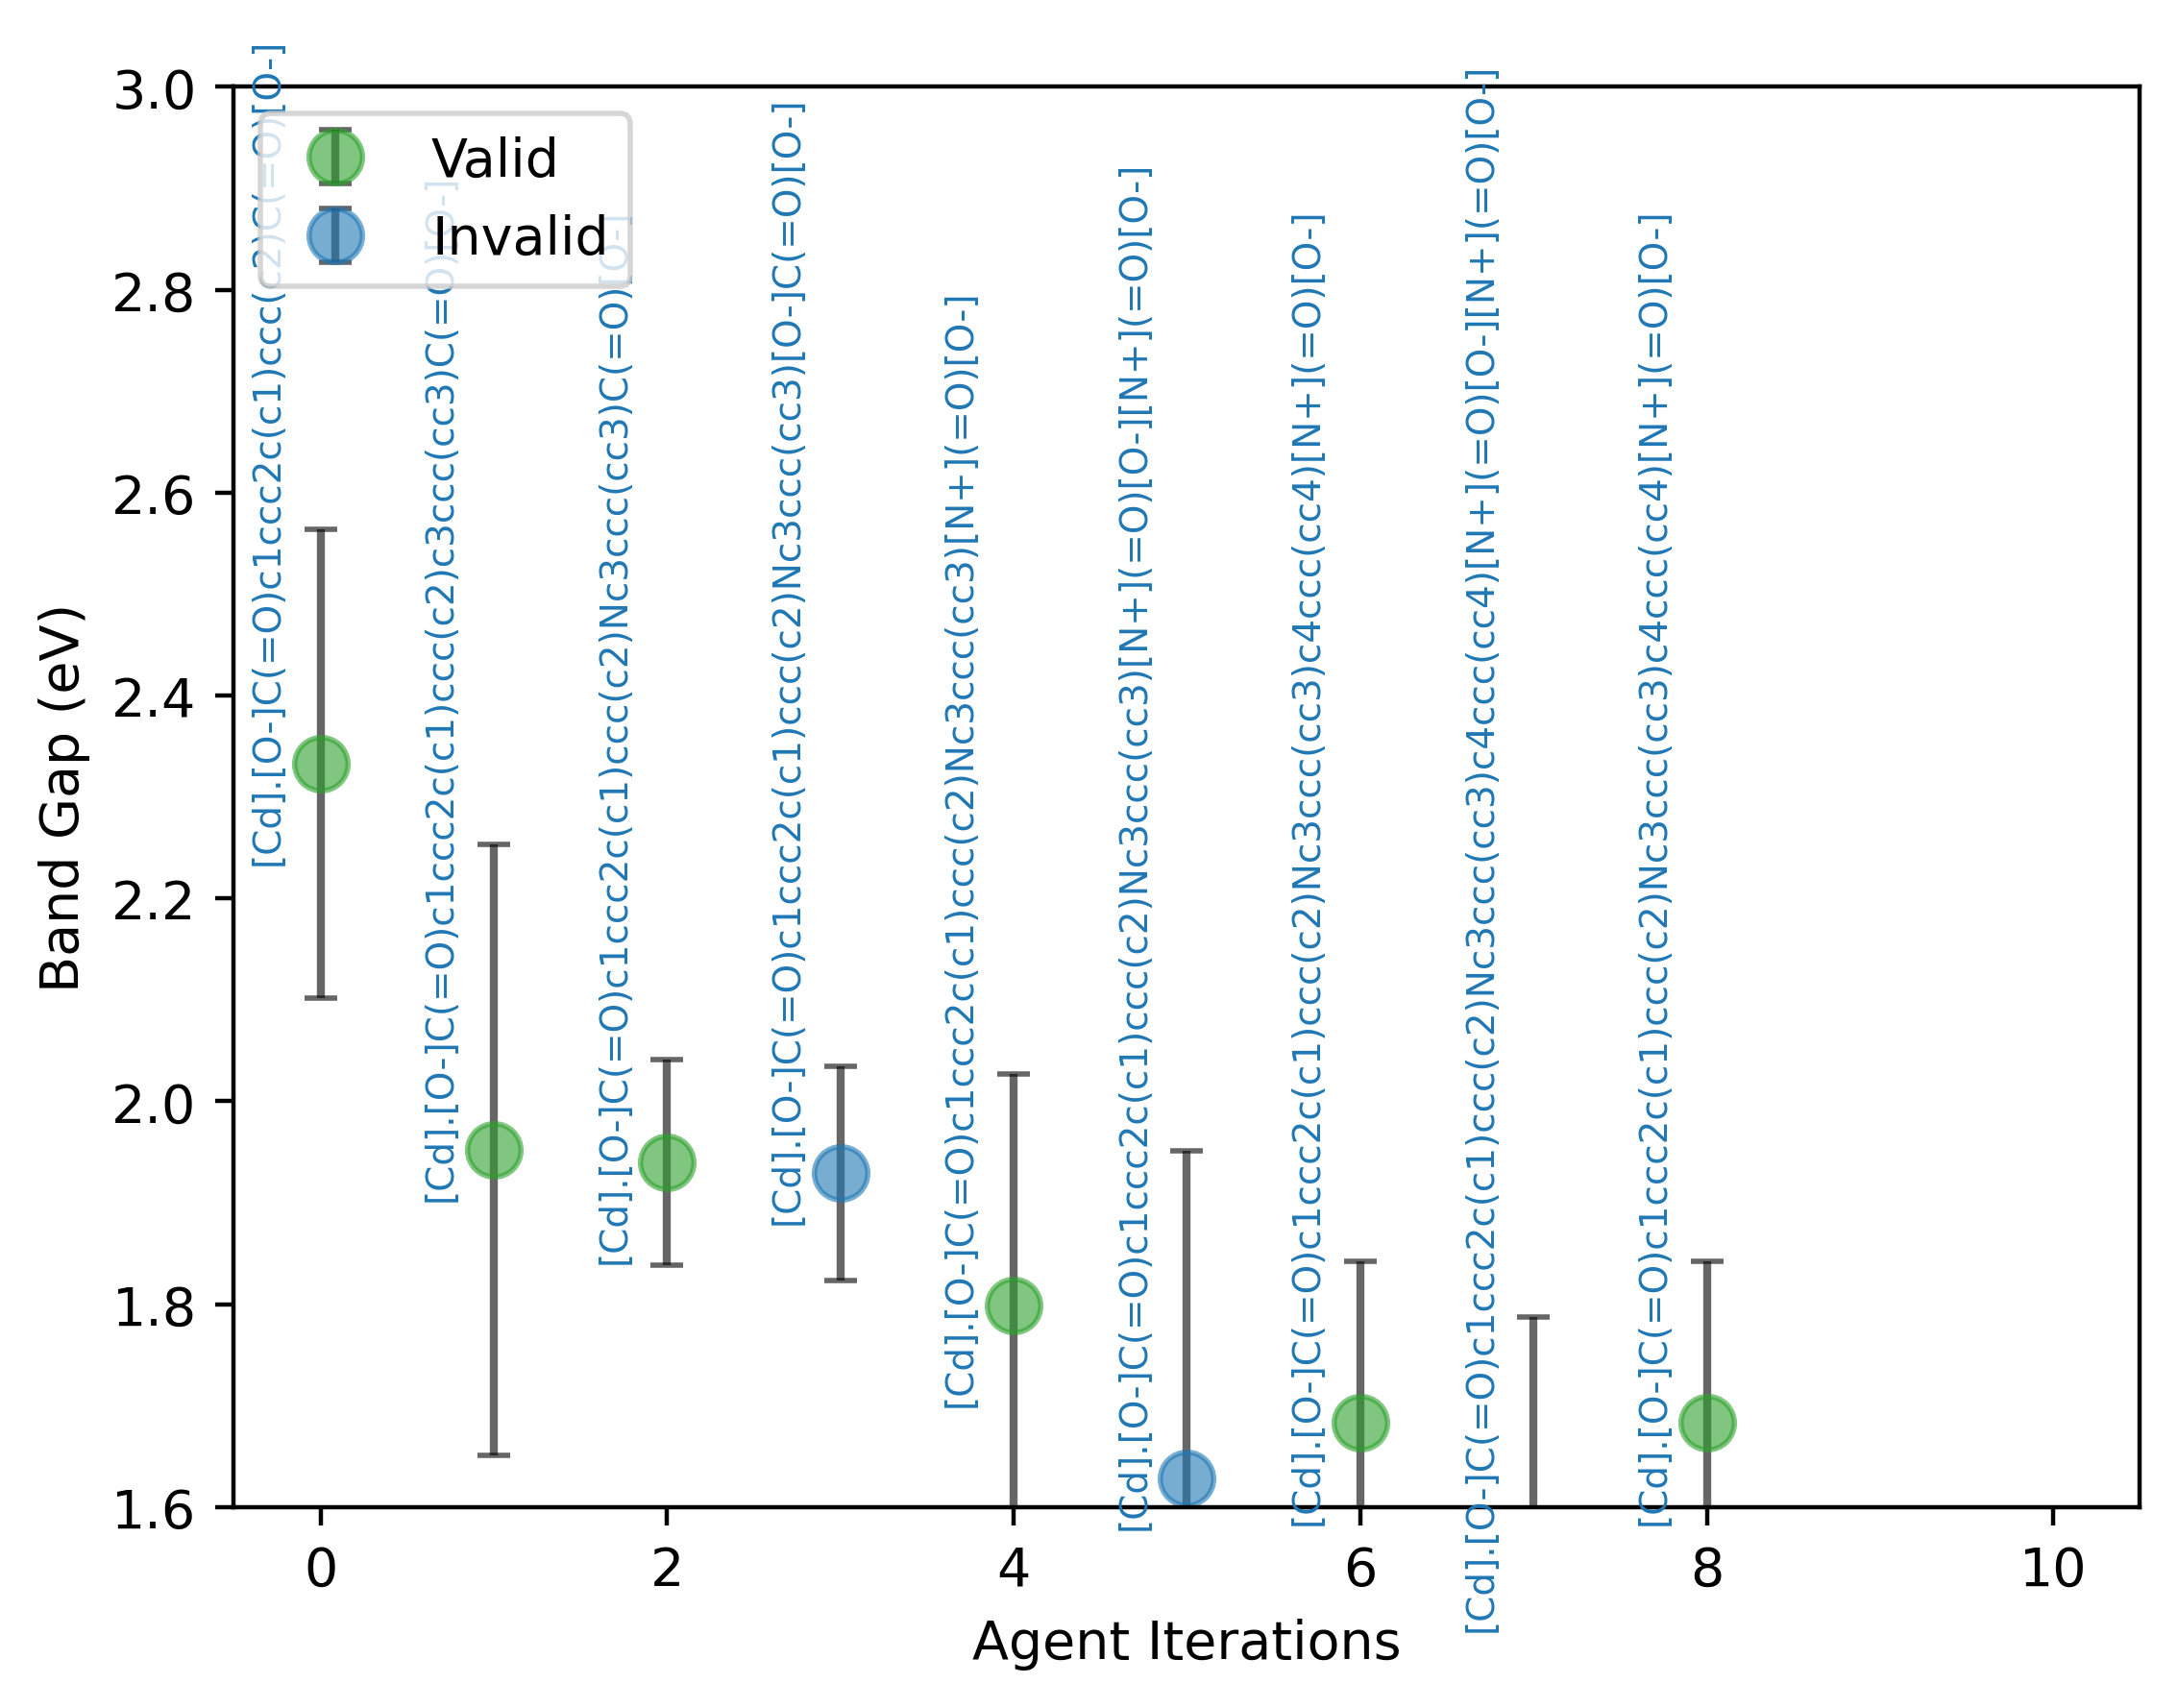

In [12]:
import matplotlib.pyplot as plt

iterations = [item['iteration'] for item in iteration_data]
mean_band_gaps = [item['data']['Mean Band Gap'] for item in iteration_data]
std_band_gaps = [item['data']['STD Band Gap'] for item in iteration_data]
smiles_labels = [item['data']['SMILES'] for item in iteration_data]
chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

plt.figure(dpi=400)

colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# Plot with error bars and color-coded points
plt.figure(dpi=400)
for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_band_gaps, std_band_gaps, colors)):
    plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
                 linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])



vertical_offsets = [(-10 + 5 * (i % 2)) for i in range(len(iterations))]  # Alternating vertical offsets

for x, y, label, offset in zip(iterations, mean_band_gaps, smiles_labels, vertical_offsets):
    plt.text(x-0.2, y + offset/100, label, verticalalignment='bottom', horizontalalignment='right', fontsize=7, color='C0', rotation=90)

ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc="upper left")

plt.xlabel('Agent Iterations')
plt.xlim([-0.5,10.5])
plt.ylim([1.6, 3])
plt.ylabel('Band Gap (eV)')

# plt.savefig(f"../results/{iteration_data[0]['data']['SMILES']}_guided.png")

In [13]:
# results = agent.invoke(input=f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else. Do 5 iterations.\n\
#             ")